In [84]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster, MeasureControl
import networkx as nx
from shapely.geometry import Point, LineString, Polygon, MultiLineString
from shapely.ops import polygonize, linemerge, unary_union, nearest_points
import os
from collections import Counter
import contextily as ctx
import osmnx as ox
from scipy.spatial import Voronoi
from sklearn.cluster import DBSCAN

Set visualization parameters

In [85]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.set(style='whitegrid')

1. Basic Data Loading and Initial Exploration

In [86]:
print("=" * 80)
print("STREET NETWORK DATA EXPLORATION FOR ROUNDABOUT DETECTION")
print("=" * 80)

STREET NETWORK DATA EXPLORATION FOR ROUNDABOUT DETECTION


In [87]:
street_network = gpd.read_file('Streets.shp')
print("\nDataset Overview:")
print(f"- Total records: {len(street_network)}")
print(f"- Memory usage: {street_network.memory_usage().sum() / 1024**2:.2f} MB")
print(f"- CRS: {street_network.crs}")


Dataset Overview:
- Total records: 494821
- Memory usage: 15.10 MB
- CRS: EPSG:4326


Check for null values

In [88]:
null_count = street_network.isnull().sum()
print("\nNull values by column:")
print(null_count[null_count > 0] if null_count.sum() > 0 else "No null values found")


Null values by column:
ST_NAME    294138
dtype: int64


Basic attribute/column analysis

In [89]:
print("\nColumns in the dataset:")
for col in street_network.columns:
    if col != 'geometry':
        unique_vals = street_network[col].nunique()
        dtype = street_network[col].dtype
        print(f"- {col}: {dtype}, {unique_vals} unique values")
        if unique_vals < 20:  # Show distribution for categorical columns
            print(f"  Values: {street_network[col].value_counts().to_dict()}")


Columns in the dataset:
- OBJECTID: int64, 494821 unique values
- LINK_ID: float64, 494821 unique values
- ST_NAME: object, 9670 unique values


2. Geometric Analysis

In [90]:
print("\n" + "=" * 80)
print("GEOMETRIC PROPERTIES ANALYSIS")
print("=" * 80)


GEOMETRIC PROPERTIES ANALYSIS


Convert to projected CRS if not already

In [91]:
if street_network.crs and "longlat" in str(street_network.crs).lower():
    # Get average latitude to determine appropriate UTM zone
    avg_lat = street_network.geometry.centroid.y.mean()
    avg_lon = street_network.geometry.centroid.x.mean()
    print(f"\nAverage location: Lat {avg_lat:.6f}, Lon {avg_lon:.6f}")
    
    projected_crs = "EPSG:3857"  # Web Mercator as default
    print(f"Converting to projected CRS: {projected_crs}")
    street_network_proj = street_network.to_crs(projected_crs)
else:
    street_network_proj = street_network.copy()
    print("\nData already in a projected CRS")


Data already in a projected CRS


Create a working copy of the projected data

In [92]:
streets = street_network_proj.copy()

Extract basic geometric properties

In [93]:
streets['length_m'] = streets.geometry.length
streets['is_linestring'] = streets.geometry.geom_type == 'LineString'
streets['is_multilinestring'] = streets.geometry.geom_type == 'MultiLineString'

C:\Users\Jsh Agarwal\AppData\Local\Temp\ipykernel_36464\143387578.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets['length_m'] = streets.geometry.length


Split MultiLineStrings into LineStrings for easier processing

In [94]:
if streets['is_multilinestring'].sum() > 0:
    print(f"\nSplitting {streets['is_multilinestring'].sum()} MultiLineStrings into individual LineStrings")
    
    # Create new rows for each part of MultiLineStrings
    multi_line_indices = streets[streets['is_multilinestring']].index
    expanded_rows = []
    
    for idx in multi_line_indices:
        row = streets.loc[idx]
        for line in row.geometry.geoms:
            new_row = row.copy()
            new_row.geometry = line
            new_row['is_multilinestring'] = False
            new_row['is_linestring'] = True
            expanded_rows.append(new_row)
    
    # Create DataFrame from expanded rows
    expanded_df = gpd.GeoDataFrame(expanded_rows, crs=streets.crs)
    
    # Remove original MultiLineStrings and add expanded linestrings
    streets = streets[~streets['is_multilinestring']]
    streets = pd.concat([streets, expanded_df])
    
    print(f"Dataset now has {len(streets)} LineString segments")

Compute additional geometric properties

In [95]:
streets['start_point'] = streets.geometry.apply(lambda line: Point(line.coords[0]) if hasattr(line, 'coords') else None)
streets['end_point'] = streets.geometry.apply(lambda line: Point(line.coords[-1]) if hasattr(line, 'coords') else None)
streets['num_points'] = streets.geometry.apply(lambda line: len(line.coords) if hasattr(line, 'coords') else 0)
streets['is_curved'] = streets['num_points'] > 2

Calculate sinuosity (ratio of line length to straight distance between endpoints)

In [96]:
def calculate_sinuosity(line):
    if not hasattr(line, 'coords') or len(line.coords) < 2:
        return np.nan
    straight_dist = Point(line.coords[0]).distance(Point(line.coords[-1]))
    return line.length / straight_dist if straight_dist > 0 else np.nan

In [97]:
streets['sinuosity'] = streets.geometry.apply(calculate_sinuosity)

Calculate bearing/direction changes

In [98]:
def calculate_bearing_changes(line):
    if not hasattr(line, 'coords') or len(line.coords) < 3:
        return 0, 0
    
    coords = list(line.coords)
    bearings = []
    
    for i in range(len(coords)-1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        bearing = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        bearings.append(bearing)
    
    # Calculate changes in bearing (angles)
    changes = [abs((b2 - b1 + 180) % 360 - 180) for b1, b2 in zip(bearings[:-1], bearings[1:])]
    avg_change = np.mean(changes) if changes else 0
    max_change = max(changes) if changes else 0
    
    return avg_change, max_change

In [99]:
streets[['avg_bearing_change', 'max_bearing_change']] = streets.geometry.apply(
    lambda line: pd.Series(calculate_bearing_changes(line))
)

Statistical summary of geometric properties

In [100]:
print("\nGeometric Properties Summary:")
for col in ['length_m', 'num_points', 'sinuosity', 'avg_bearing_change', 'max_bearing_change']:
    print(f"\n{col}:")
    print(streets[col].describe())


Geometric Properties Summary:

length_m:
count    494821.000000
mean          0.002791
std           0.011717
min           0.000020
25%           0.000524
50%           0.001241
75%           0.003170
max           3.966314
Name: length_m, dtype: float64

num_points:
count    494821.000000
mean          4.528274
std           4.879016
min           2.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         169.000000
Name: num_points, dtype: float64

sinuosity:
count    494821.000000
mean          1.037478
std           0.188573
min           1.000000
25%           1.000000
50%           1.000127
75%           1.012919
max          33.101686
Name: sinuosity, dtype: float64

avg_bearing_change:
count    494821.000000
mean          7.977046
std          14.428081
min           0.000000
25%           0.000000
50%           1.218875
75%          10.738560
max         154.653824
Name: avg_bearing_change, dtype: float64

max_bearing_change:
count    494821.00

Plot histograms of key geometric properties

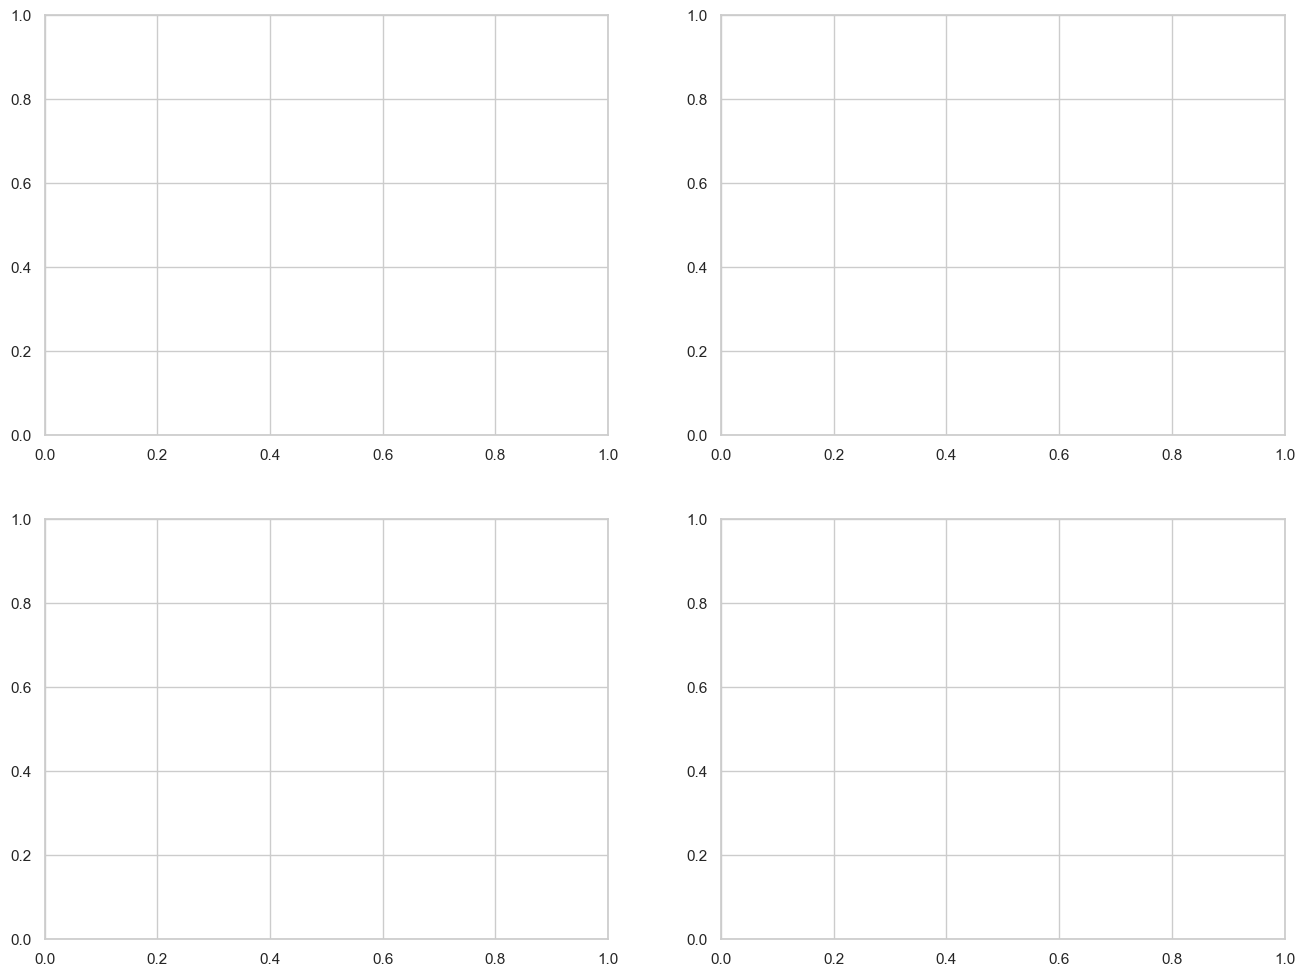

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

Use matplotlib's hist directly instead of pandas' hist method

In [102]:
axes[0,0].hist(streets['length_m'].dropna(), bins=50)
axes[0,0].set_title('Road Segment Lengths (meters)')
axes[0,0].set_xlabel('Length (m)')
axes[0,0].set_ylabel('Count')

Text(4.444444444444459, 0.5, 'Count')

In [103]:
axes[0,1].hist(streets['sinuosity'].dropna(), bins=50)
axes[0,1].set_title('Road Sinuosity (ratio of length to straight-line distance)')
axes[0,1].set_xlabel('Sinuosity')
axes[0,1].set_ylabel('Count')

Text(680.8080808080806, 0.5, 'Count')

In [104]:
axes[1,0].hist(streets['avg_bearing_change'].dropna(), bins=50)
axes[1,0].set_title('Average Bearing Change in Road Segments')
axes[1,0].set_xlabel('Degrees')
axes[1,0].set_ylabel('Count')

Text(4.444444444444459, 0.5, 'Count')

In [105]:
axes[1,1].hist(streets[streets['is_curved']]['num_points'].dropna(), bins=50)
axes[1,1].set_title('Number of Points in Curved Road Segments')
axes[1,1].set_xlabel('Number of Points')
axes[1,1].set_ylabel('Count')

Text(680.8080808080806, 0.5, 'Count')

In [106]:
plt.tight_layout()
plt.savefig('geometric_properties_histograms.png')

<Figure size 1500x1000 with 0 Axes>

3. Network Topology Analysis

In [107]:
print("\n" + "=" * 80)
print("NETWORK TOPOLOGY ANALYSIS")
print("=" * 80)


NETWORK TOPOLOGY ANALYSIS


Create a network graph

In [108]:
G = nx.Graph()

Extract endpoints of each street segment

In [109]:
print("\nExtracting network topology...")
endpoints = []
for idx, row in streets.iterrows():
    if hasattr(row.geometry, 'coords') and len(row.geometry.coords) >= 2:
        start = tuple(row.geometry.coords[0])
        end = tuple(row.geometry.coords[-1])
        G.add_edge(start, end, 
                   length=row['length_m'], 
                   id=idx, 
                   sinuosity=row['sinuosity'],
                   geometry=row.geometry)
        endpoints.extend([start, end])


Extracting network topology...


Analyze node degrees (number of connections at each point)

In [110]:
node_degrees = dict(G.degree())
degree_counts = Counter(node_degrees.values())

In [111]:
print("\nConnection Point Distribution:")
for degree, count in sorted(degree_counts.items()):
    print(f"- Degree {degree}: {count} points")


Connection Point Distribution:
- Degree 1: 70245 points
- Degree 2: 164625 points
- Degree 3: 161573 points
- Degree 4: 25257 points
- Degree 5: 811 points
- Degree 6: 47 points
- Degree 7: 9 points


Create a DataFrame of endpoints/nodes

In [112]:
nodes_df = pd.DataFrame(list(node_degrees.items()), columns=['coords', 'degree'])
nodes_gdf = gpd.GeoDataFrame(
    nodes_df, 
    geometry=[Point(coords) for coords in nodes_df['coords']],
    crs=streets.crs
)

Find potential intersection points (nodes with degree >= 3)

In [113]:
intersections = nodes_gdf[nodes_gdf['degree'] >= 3].copy()
print(f"\nFound {len(intersections)} intersections (nodes with 3+ connections)")


Found 187697 intersections (nodes with 3+ connections)


Extract cycles (potential roundabouts)

In [114]:
print("\nFinding cycles in road network...")


Finding cycles in road network...


Choose detection method: 'neighborhood' or 'geometric'

In [115]:
detection_method = 'neighborhood'  # Change to 'geometric' for the alternative approach

In [116]:
if detection_method == 'neighborhood':
    try:
        # Define a more efficient approach that focuses on neighborhood subgraphs
        def find_potential_roundabouts(G, max_size=8):
            """Find potential roundabouts using neighborhood analysis"""
            potential_roundabouts = []
            
            # Find nodes with degree >= 3 (intersections)
            intersections = [node for node, deg in G.degree() if deg >= 3]
            print(f"Analyzing {len(intersections)} intersection nodes")
            
            # For each intersection, look for small cycles in its neighborhood
            for i, node in enumerate(intersections):
                if i % 50 == 0 and i > 0:
                    print(f"Processing intersection {i}/{len(intersections)}")
                    
                # Get neighbors within 2 hops
                neighbors = set([node])
                for n in G.neighbors(node):
                    neighbors.add(n)
                    neighbors.update(G.neighbors(n))
                
                # Skip if neighborhood is too large (performance optimization)
                if len(neighbors) > 20:
                    continue
                
                # Create subgraph of the neighborhood
                subgraph = G.subgraph(neighbors)
                
                # Find cycles in this smaller subgraph
                try:
                    from networkx.algorithms.cycles import cycle_basis
                    local_cycles = cycle_basis(subgraph)
                    # Filter by size
                    local_small_cycles = [cycle for cycle in local_cycles 
                                        if 3 <= len(cycle) <= max_size]
                    potential_roundabouts.extend(local_small_cycles)
                except Exception:
                    continue
            
            return potential_roundabouts
        small_cycles = find_potential_roundabouts(G)
        print(f"Found {len(small_cycles)} small cycles (3-8 nodes) that could be roundabouts")
    except Exception as e:
        print(f"Error finding cycles: {e}")
        small_cycles = []

Analyzing 187697 intersection nodes
Processing intersection 50/187697
Processing intersection 100/187697
Processing intersection 150/187697
Processing intersection 200/187697
Processing intersection 250/187697
Processing intersection 300/187697
Processing intersection 350/187697
Processing intersection 400/187697
Processing intersection 450/187697
Processing intersection 500/187697
Processing intersection 550/187697
Processing intersection 600/187697
Processing intersection 650/187697
Processing intersection 700/187697
Processing intersection 750/187697
Processing intersection 800/187697
Processing intersection 850/187697
Processing intersection 900/187697
Processing intersection 950/187697
Processing intersection 1000/187697
Processing intersection 1050/187697
Processing intersection 1100/187697
Processing intersection 1150/187697
Processing intersection 1200/187697
Processing intersection 1250/187697
Processing intersection 1300/187697
Processing intersection 1350/187697
Processing i

4. Detect Potential Roundabouts Using Multiple Methods

In [117]:
print("\n" + "=" * 80)
print("POTENTIAL ROUNDABOUT DETECTION")
print("=" * 80)


POTENTIAL ROUNDABOUT DETECTION


4.1. Method 1: Graph-based approach using cycles

In [118]:
roundabout_candidates_graph = []

In [119]:
if small_cycles:
    print("\nAnalyzing network cycles...")
    
    for cycle_idx, cycle in enumerate(small_cycles):
        # Convert node coordinates to a polygon
        polygon = Polygon(cycle)
        
        # Calculate basic metrics
        area = polygon.area
        perimeter = polygon.length
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Filter based on reasonable roundabout characteristics
        if 50 < area < 10000 and circularity > 0.6:
            roundabout_candidates_graph.append({
                'geometry': polygon,
                'method': 'graph_cycle',
                'cycle_id': cycle_idx,
                'nodes': len(cycle),
                'area': area,
                'perimeter': perimeter,
                'circularity': circularity
            })
    
    print(f"Method 1: Found {len(roundabout_candidates_graph)} potential roundabouts from graph cycles")

else:  # geometric approach
    try:
        import math
        
        # Create a dictionary of intersection nodes (degree >= 3)
        intersection_points = {}
        for node, degree in G.degree():
            if degree >= 3:
                intersection_points[node] = degree
        
        print(f"Analyzing {len(intersection_points)} intersection points")
        
        # For each intersection, analyze nearby road segments
        max_radius = 50  # meters
        roundabout_patterns = []
        
        for i, (point, degree) in enumerate(intersection_points.items()):
            if i % 100 == 0 and i > 0:
                print(f"Processed {i}/{len(intersection_points)} intersections")
                
            # Create a buffer around the point
            p = Point(point)
            buffer = p.buffer(max_radius)
            
            # Find edges with at least one endpoint in the buffer
            nearby_edges = []
            for u, v, data in G.edges(data=True):
                if Point(u).within(buffer) or Point(v).within(buffer):
                    nearby_edges.append((u, v, data))
            
            # Skip if too few edges
            if len(nearby_edges) < 3:
                continue
                
            # Check if the segments form a circular pattern by analyzing edge directions
            directions = []
            for u, v, _ in nearby_edges:
                dx, dy = v[0] - u[0], v[1] - u[1]
                angle = math.degrees(math.atan2(dy, dx)) % 360
                directions.append(angle)
            
            # Group directions into 8 sectors (N, NE, E, SE, S, SW, W, NW)
            sectors = [0] * 8
            for angle in directions:
                sector_idx = int((angle + 22.5) % 360 / 45)
                sectors[sector_idx] += 1
            
            # If we have road segments in at least 4 different sectors, 
            # consider it a potential roundabout
            if sum(1 for s in sectors if s > 0) >= 4:
                # For compatibility with the rest of the code, we need to create a cycle
                # We'll use the nearby edge endpoints to form a polygon
                cycle_points = []
                for u, v, _ in nearby_edges:
                    if Point(u).within(buffer):
                        cycle_points.append(u)
                    if Point(v).within(buffer):
                        cycle_points.append(v)
                
                # Get unique points
                unique_points = []
                for pt in cycle_points:
                    if pt not in unique_points:
                        unique_points.append(pt)
                
                # Only add if we have enough points for a polygon
                if len(unique_points) >= 3:
                    roundabout_patterns.append(unique_points)
        
        # Set small_cycles to the detected patterns
        small_cycles = roundabout_patterns
        print(f"Found {len(small_cycles)} potential roundabout patterns")
        
    except Exception as e:
        print(f"Error in geometric roundabout detection: {e}")
        small_cycles = []


Analyzing network cycles...
Method 1: Found 0 potential roundabouts from graph cycles


4.2. Method 2: Geometry-based approach using polygonization

In [120]:
print("\nDetecting closed loops from line segments...")


Detecting closed loops from line segments...


Get all line geometries

In [121]:
lines = list(streets.geometry)

Try to merge lines and polygonize

In [122]:
try:
    # Create boundaries from merged lines
    merged_lines = linemerge(lines)
    boundaries = unary_union(merged_lines)
    potential_polygons = list(polygonize(boundaries))
    
    print(f"Detected {len(potential_polygons)} closed polygons from street segments")
    
    # Filter polygons by shape characteristics
    roundabout_candidates_geom = []
    for poly_idx, polygon in enumerate(potential_polygons):
        # Calculate metrics
        area = polygon.area
        perimeter = polygon.length
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Use slightly different thresholds than before
        if 50 < area < 10000 and circularity > 0.6:
            roundabout_candidates_geom.append({
                'geometry': polygon,
                'method': 'polygonization',
                'poly_id': poly_idx,
                'area': area,
                'perimeter': perimeter,
                'circularity': circularity
            })
    
    print(f"Method 2: Found {len(roundabout_candidates_geom)} potential roundabouts from polygonization")
    
except Exception as e:
    print(f"Error in polygonization: {e}")
    roundabout_candidates_geom = []

Detected 72471 closed polygons from street segments
Method 2: Found 0 potential roundabouts from polygonization


4.3. Method 3: Intersection-based approach

In [123]:
print("\nAnalyzing complex intersections...")


Analyzing complex intersections...


For each intersection (nodes with degree >= 3)

In [ ]:
roundabout_candidates_intersect = []
if len(intersections) > 0:
    for idx, intersection in intersections.iterrows():
        # Get coordinate of intersection point
        point = intersection.geometry
        
        # Find all street segments near this intersection (buffer search)
        buffer_dist = 50  # meters
        buffer = point.buffer(buffer_dist)
        near_segments = streets[streets.geometry.intersects(buffer)]
        
        # Skip if too few segments
        if len(near_segments) < 3:
            continue
        
        # Analyze the arrangement of segments
        segment_endpoints = []
        for _, segment in near_segments.iterrows():
            if hasattr(segment.geometry, 'coords'):
                segment_endpoints.extend(list(segment.geometry.coords))
        
        # Skip if too few points
        if len(segment_endpoints) < 6:
            continue
            
        # Calculate the convex hull of these points
        points = [Point(p) for p in segment_endpoints]
        multi_point = unary_union(points)
        hull = multi_point.convex_hull
        
        # Calculate hull metrics
        area = hull.area
        perimeter = hull.length
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Filter based on roundabout characteristics
        if 50 < area < 10000 and circularity > 0.7:  # stricter circularity here
            roundabout_candidates_intersect.append({
                'geometry': hull,
                'method': 'intersection',
                'intersection_id': idx,
                'connecting_roads': len(near_segments),
                'area': area,
                'perimeter': perimeter,
                'circularity': circularity
            })
    
    print(f"Method 3: Found {len(roundabout_candidates_intersect)} potential roundabouts from intersections")

5. Combine all candidates from different methods

In [ ]:
all_candidates = roundabout_candidates_graph + roundabout_candidates_geom + roundabout_candidates_intersect

In [ ]:
if not all_candidates:
    print("\nNo roundabout candidates found by any method.")
    roundabout_gdf = gpd.GeoDataFrame(geometry=[])
else:
    print(f"\nTotal candidates from all methods: {len(all_candidates)}")
    roundabout_gdf = gpd.GeoDataFrame(all_candidates, crs=streets.crs)
    
    # Remove duplicates by spatial proximity
    # Two candidates are duplicates if their centroids are within X meters
    centroids = roundabout_gdf.copy()
    centroids.geometry = centroids.geometry.centroid
    
    # Use DBSCAN for spatial clustering of duplicate candidates
    if len(centroids) > 1:
        # Extract coordinates for DBSCAN
        coords = np.array([
            [geom.x, geom.y] for geom in centroids.geometry
        ])
        
        # Cluster with DBSCAN (eps = 50 meters)
        clustering = DBSCAN(eps=50, min_samples=1).fit(coords)
        centroids['cluster'] = clustering.labels_
        roundabout_gdf['cluster'] = centroids['cluster']
        
        # Find the best candidate in each cluster (highest circularity)
        unique_clusters = roundabout_gdf['cluster'].unique()
        best_candidates = []
        
        for cluster in unique_clusters:
            cluster_candidates = roundabout_gdf[roundabout_gdf['cluster'] == cluster]
            best_idx = cluster_candidates['circularity'].idxmax()
            best_candidates.append(roundabout_gdf.loc[best_idx])
        
        # Create GeoDataFrame of best candidates
        roundabout_gdf = gpd.GeoDataFrame(best_candidates, crs=streets.crs)
        print(f"After removing duplicates: {len(roundabout_gdf)} unique roundabout candidates")

6. Advanced Analysis of Candidates

In [ ]:
if not roundabout_gdf.empty:
    print("\n" + "=" * 80)
    print("DETAILED ANALYSIS OF ROUNDABOUT CANDIDATES")
    print("=" * 80)
    
    # Calculate additional metrics for each candidate
    roundabout_gdf['centroid'] = roundabout_gdf.geometry.centroid
    
    # Number of road connections to each candidate
    def count_connections(polygon, road_gdf, buffer_dist=10):
        buffer = polygon.buffer(buffer_dist)
        intersecting = road_gdf[road_gdf.geometry.intersects(buffer)]
        return len(intersecting)
    
    roundabout_gdf['road_connections'] = roundabout_gdf.geometry.apply(
        lambda poly: count_connections(poly, streets, 10)
    )
    
    # Statistical summary of roundabout candidates
    print("\nRoundabout Candidate Statistics:")
    for col in ['area', 'perimeter', 'circularity', 'road_connections']:
        if col in roundabout_gdf.columns:
            print(f"\n{col}:")
            print(roundabout_gdf[col].describe())
    
    # Method distribution
    if 'method' in roundabout_gdf.columns:
        method_counts = roundabout_gdf['method'].value_counts()
        print("\nDetection Method Distribution:")
        for method, count in method_counts.items():
            print(f"- {method}: {count}")

7. Visualization

In [ ]:
print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

Convert projection to WGS84 for web mapping

In [ ]:
streets_wgs84 = streets.to_crs("EPSG:4326")
roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326") if not roundabout_gdf.empty else gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

7.1. Static map with Matplotlib

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

Plot the street network

In [ ]:
streets.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.7)

Add detected roundabouts if any

In [ ]:
if not roundabout_gdf.empty:
    roundabout_gdf.plot(ax=ax, color='red', alpha=0.5)

Add intersections (nodes with degree >= 3)

In [ ]:
if len(intersections) > 0:
    intersections.plot(ax=ax, color='blue', markersize=5)

Add title and legend

In [ ]:
plt.title('Street Network Analysis for Roundabout Detection', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='gray', lw=1, label='Streets'))
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Intersections', linestyle='None'))
if not roundabout_gdf.empty:
    handles.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='Potential Roundabouts', linestyle='None'))
ax.legend(handles=handles)

In [ ]:
plt.savefig('street_network_analysis.png', bbox_inches='tight', dpi=300)
print("Static map saved as 'street_network_analysis.png'")

7.2. Interactive Folium Map

Create a map centered on the data

In [ ]:
map_center = [
    streets_wgs84.geometry.centroid.y.mean(), 
    streets_wgs84.geometry.centroid.x.mean()
]
m = folium.Map(location=map_center, zoom_start=14, tiles='OpenStreetMap')

Add street network

In [ ]:
folium.GeoJson(
    streets_wgs84,
    name="Street Network",
    style_function=lambda x: {
        'color': 'gray',
        'weight': 2,
        'opacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['length_m', 'sinuosity'],
        aliases=['Length (m)', 'Sinuosity'],
        localize=True
    )
).add_to(m)

Add intersections

In [ ]:
if len(intersections) > 0:
    intersections_wgs84 = intersections.to_crs("EPSG:4326")
    
    # Create a feature group for intersections
    intersection_group = folium.FeatureGroup(name="Intersections")
    
    # Add each intersection
    for idx, row in intersections_wgs84.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            tooltip=f"Intersection: {row['degree']} connections"
        ).add_to(intersection_group)
    
    intersection_group.add_to(m)

Add roundabout candidates if any

In [ ]:
if not roundabout_gdf_wgs84.empty:
    # Create a feature group for roundabouts
    roundabout_group = folium.FeatureGroup(name="Potential Roundabouts")
    
    # Add each roundabout candidate
    for idx, row in roundabout_gdf_wgs84.iterrows():
        # Create popup content
        popup_content = f"""
        <b>Potential Roundabout</b><br>
        Area: {row['area']:.1f} mÂ²<br>
        Perimeter: {row['perimeter']:.1f} m<br>
        Circularity: {row['circularity']:.3f}<br>
        """
        
        if 'method' in row:
            popup_content += f"Detection Method: {row['method']}<br>"
        
        if 'road_connections' in row:
            popup_content += f"Road Connections: {row['road_connections']}<br>"
        
        # Get polygon coordinates
        coords = []
        if row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
            # For multipolygons, we just take the first polygon
            if row.geometry.geom_type == 'MultiPolygon':
                polygon = row.geometry.geoms[0]
            else:
                polygon = row.geometry
                
            # Extract exterior coordinates in the format (lat, lon) for Folium
            coords = [(lat, lon) for lon, lat in polygon.exterior.coords]
        
        # Add polygon to map
        folium.Polygon(
            locations=coords,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.4,
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(roundabout_group)
    
    roundabout_group.add_to(m)

Add measurement tool

In [ ]:
MeasureControl().add_to(m)

Add layer control

In [ ]:
folium.LayerControl().add_to(m)

Save interactive map

In [ ]:
m.save('roundabout_detection_interactive.html')
print("Interactive map saved as 'roundabout_detection_interactive.html'")

8. Additional Specialized Visualizations<br>
8.1. Road sinuosity map

In [ ]:
sinuosity_map = folium.Map(location=map_center, zoom_start=14, tiles='OpenStreetMap')

Add street network colored by sinuosity

In [ ]:
streets_wgs84['sinuosity_category'] = pd.cut(
    streets_wgs84['sinuosity'].fillna(1),
    bins=[1, 1.05, 1.1, 1.2, 1.5, 100],
    labels=['Straight', 'Slightly curved', 'Curved', 'Very curved', 'Extremely curved']
)

In [ ]:
color_dict = {
    'Straight': 'blue',
    'Slightly curved': 'green',
    'Curved': 'yellow',
    'Very curved': 'orange',
    'Extremely curved': 'red'
}

In [ ]:
for category, color in color_dict.items():
    category_roads = streets_wgs84[streets_wgs84['sinuosity_category'] == category]
    if len(category_roads) > 0:
        folium.GeoJson(
            category_roads,
            name=f"{category} roads",
            style_function=lambda x, color=color: {
                'color': color,
                'weight': 3,
                'opacity': 0.7
            }
        ).add_to(sinuosity_map)

Add layer control

In [ ]:
folium.LayerControl().add_to(sinuosity_map)
sinuosity_map.save('road_sinuosity_map.html')
print("Road sinuosity map saved as 'road_sinuosity_map.html'")

8.2. Intersection density heatmap

In [ ]:
if len(intersections) > 0:
    heatmap = folium.Map(location=map_center, zoom_start=13, tiles='OpenStreetMap')
    
    # Convert intersections to WGS84 if needed
    intersections_wgs84 = intersections.to_crs("EPSG:4326")
    
    # Create heatmap data
    heat_data = [[point.y, point.x] for point in intersections_wgs84.geometry]
    
    # Add the heatmap layer
    HeatMap(heat_data, radius=15).add_to(heatmap)
    
    heatmap.save('intersection_heatmap.html')
    print("Intersection density heatmap saved as 'intersection_heatmap.html'")

9. Prepare and Save Results to GeoJSONL

In [ ]:
if not roundabout_gdf_wgs84.empty:
    print("\n" + "=" * 80)
    print("SAVING RESULTS")
    print("=" * 80)
    
    # Ensure everything is in WGS84 for standard GeoJSON
    roundabout_gdf_wgs84 = roundabout_gdf_wgs84.to_crs("EPSG:4326") 

    # Save to GeoJSONL (one feature per line)
    with open('roundabout_candidates.geojsonl', 'w') as f:
        for idx, row in roundabout_gdf_wgs84.iterrows():
            # Convert all properties to serializable types
            properties = {}
            for col in roundabout_gdf_wgs84.columns:
                if col != 'geometry' and col != 'centroid':
                    val = row[col]
                    # Handle non-serializable types
                    if isinstance(val, (np.integer, np.floating)):
                        val = float(val)
                    elif isinstance(val, np.bool_):
                        val = bool(val)
                    properties[col] = val
            
            geojson_feature = {
                'type': 'Feature',
                'geometry': row.geometry.__geo_interface__,
                'properties': properties
            }
            f.write(f"{pd.Series(geojson_feature).to_json()}\n")
    print(f"GeoJSONL file created with {len(roundabout_gdf_wgs84)} roundabout candidates")
    print("Saved to: roundabout_candidates.geojsonl")

10. Summary Statistics and Next Steps

In [ ]:
print("\n" + "=" * 80)
print("SUMMARY AND POTENTIAL SOLUTION APPROACHES")
print("=" * 80)

In [ ]:
print("\nDataset Summary:")
print(f"- {len(streets)} road segments analyzed")
print(f"- Network density: {len(streets) / streets.geometry.area.sum() * 1000000:.2f} segments per kmÂ²")
if len(intersections) > 0:
    print(f"- {len(intersections)} complex intersections identified")
print(f"- {len(roundabout_gdf) if not roundabout_gdf.empty else 0} potential roundabouts detected")

In [ ]:
print("\nPotential Solution Approaches:")
print("1. Geometric pattern matching:")
print("   - Circle/ellipse fitting to closed loops")
print("   - Sinuosity and curvature analysis")
print("   - Fixed radius buffer analysis around intersections")

In [ ]:
print("\n2. Network topology analysis:")
print("   - Circular node patterns in graph representation")
print("   - Degree distribution at nodes")
print("   - Betweenness centrality for identifying important junctions")

In [ ]:
print("\n3. Machine learning approaches:")
print("   - Feature engineering based on geometric/topological properties")
print("   - Supervised learning with labeled roundabouts")
print("   - Pattern recognition using CNNs on rasterized network data")

In [ ]:
print("\n4. Hybrid approaches:")
print("   - Combine multiple detection methods")
print("   - Sequential filtering with increasing precision")
print("   - Consensus voting across different methods")

In [ ]:
print("\n" + "=" * 80)
print("EDA COMPLETE")
print("=" * 80)